In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator

In [2]:
# load data
iris_raw = load_iris()
iris_all = pd.DataFrame(np.hstack([iris_raw.data, iris_raw.target.reshape(-1, 1)]), columns=iris_raw.feature_names+['species'])
iris_all.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [4]:
# I am going to split the items into train and test sets
# I am going to use cross validation on the train sets for model comparison
# so I don't need a seperate validation set

X, X_test, y, y_test = train_test_split(iris_all[iris_raw.feature_names], iris_all['species'])

# for use in visualizations
iris_train = X.copy()
iris_train['species'] = y

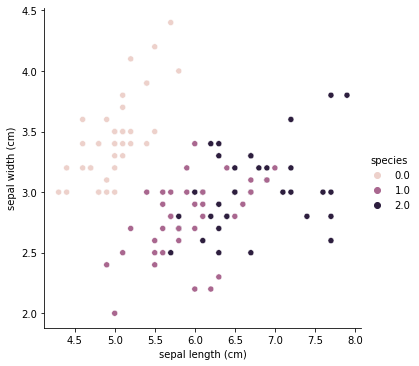

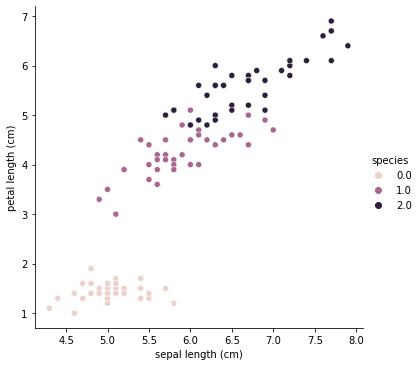

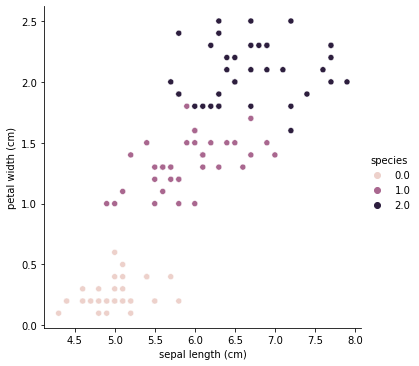

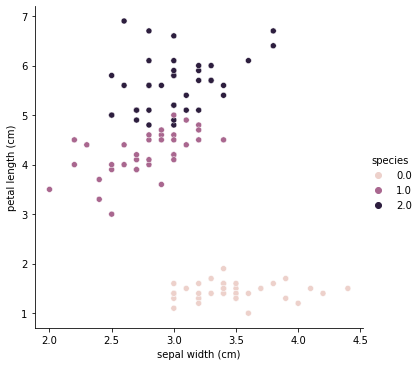

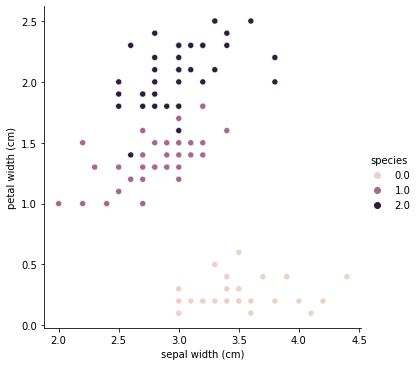

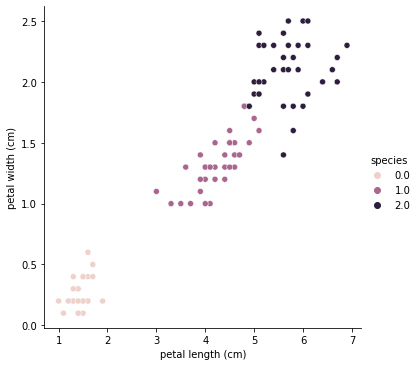

In [7]:
for i, j in combinations(iris_raw.feature_names, 2):
    sns.relplot(x=i, y=j, hue='species', data=iris_train)

Looking at these graphs, it seems like setosa (species 0) is quite distinct form the other two species on most variables. Classifying these is clearly going to be easy compared to distinguishing between versicolor and virginica.

I think the best plan is probably to use a support vector classifier with a radial basis kernel to distinguish between setosa and not setosa. Judging by how far apart the distributions are, this should be able to get ~100% accuracy. Then I can use a more complicated model to distinguish between versicolor and verginica.

This plan has the advantage that I can use a high-bias model for the easy tasks and a high-variance model for the more difficult task, hopefully reducing the total amount of variance I have to include.

In [8]:
# but first, a baseline
cross_validate(RandomForestClassifier(), X, y, scoring='f1_macro')

{'fit_time': array([0.11942291, 0.10794902, 0.10753489, 0.10420108, 0.10482001]),
 'score_time': array([0.00956416, 0.00949621, 0.01016212, 0.00921607, 0.00904989]),
 'test_score': array([0.95555556, 0.95555556, 1.        , 0.91071429, 0.95475113])}

Hmm, this is really good. I did not expect any of my models to perform this well, least of all an out of the box random forest. Maybe the lesson here is to always start with the baseline.

This kind of suggests that the best path forward might be to double down on the random forest and see if I can get better results with hyper-parameter tuning. I am kind of worried about overfitting though, and I kind of want to see if my original idea would work. So, I am still going to write it.

In [18]:
class CustomModel(BaseEstimator, ClassifierMixin):
    def __init__(self, setosa_model=SVC(), other_model=RandomForestClassifier(n_estimators=100)):
        self.setosa_model = setosa_model
        self.other_model = other_model
    
    def fit(self, X, y):
        is_setosa = (y == 0)
        self.setosa_model.fit(X, is_setosa)
        
        # the key strategy is only fitting this model to the non setosa data
        self.other_model.fit(X[~is_setosa], y[~is_setosa])
    
    def predict(self, X):
        # figure out which ones are setosa
        ans = self.setosa_model.predict(X).astype('int')
        
        # set setosas to zero, others to 1 (numpy makes this kinda hard)
        ans[ans==1], ans[ans==0], ans[ans==2] = 2, 1, 0
        
        # do the predictions for the others
        ans[ans==1] = self.other_model.predict(X[ans==1])
        
        return ans

cross_validate(CustomModel(), X, y, scoring='f1_macro')

{'fit_time': array([0.12697721, 0.1091888 , 0.10770321, 0.10864329, 0.10387611]),
 'score_time': array([0.01111698, 0.01050186, 0.01080871, 0.01006269, 0.010427  ]),
 'test_score': array([0.95555556, 0.91071429, 1.        , 0.91071429, 0.95475113])}

Hmm, almost the exact same. I guess the random forest knows what it's doing. For my final model, I will do a hyperparameter search across the random forest and call it a day.

In [25]:
search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions={
        'n_estimators': [2**i for i in range(10)],
        'criterion': ['entropy', 'gini'],
        'max_depth': [2**i for i in range(2, 9, 2)]
    },
    n_iter=30,
    n_jobs=-1,
    verbose=2,
    refit=True
)

search.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 135 out of 150 | elapsed:    6.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.6s finished


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [4, 16, 64, 256],
                                        'n_estimators': [1, 2, 4, 8, 16, 32, 64,
                                                         128, 256, 512]},
                   verbose=2)

In [26]:
search.score(X_test, y_test)

0.9210526315789473

Well, I guess that's okay. It's not as good as I was getting earlier cross validating the out of the box random forest (